In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit
from matplotlib.cm import ScalarMappable

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
mu_0 = sp.constants.mu_0
hbar = sp.constants.hbar
h = sp.constants.h
g = sp.constants.g
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]
inch = 25.4e-3

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [7]:
def Bfield(r):
    M = 1.2 #in T (also known as remanance)
    V = 10*25*3e-9 #in m3, volume of magnet stack
    m = num*M*V*np.array([[0, 0, 1], [0, 0, -1],[0, 0, 1], [0, 0, -1]])/mu_0 #magnetic moment of the magnet
    a = 39e-3
    ax = 30e-3
    posm = np.array([[ax, a, 0], [ax, -a, 0], [-ax, a, 0], [-ax, -a, 0]]) #position of the magents
    b = 0
    for i, mi in enumerate(m):
        dist = np.sqrt(np.sum(np.square(r-posm[i])))
        b += mu_0/4/np.pi * (3*(r-posm[i])*np.dot(mi, r-posm[i])/dist**5 - mi/dist**3)
    return b

# Bfield with 4 magnet stacks:

In [8]:
num=3

y = np.linspace(-1*inch, 1*inch, 15)
z = np.linspace(-1*inch, 1*inch, 15)

rb = np.array([[np.array([0,yy,zz]) for yy in y] for zz in z])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(z))]).transpose()
Bx = B[:,:][0]
By = B[:,:][1]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bz**2+Bx**2)

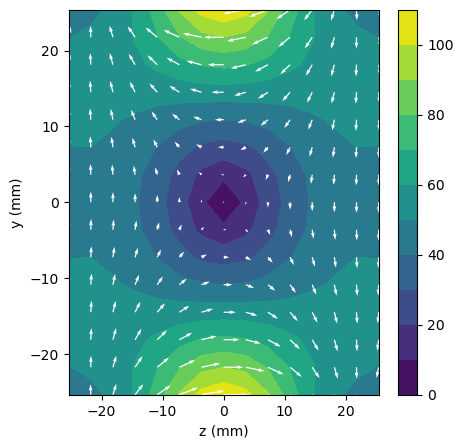

In [9]:
plt.figure(figsize=(5,5))
plot = plt.contourf(z*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],z[0],z[-1]], origin='lower', levels=10)
plt.quiver(z*1e3, y*1e3, Bz, By, color='white')
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [10]:
def line(x, a, b):
    return a*(x)+b

gradient: -35.032502418560604 G/cm


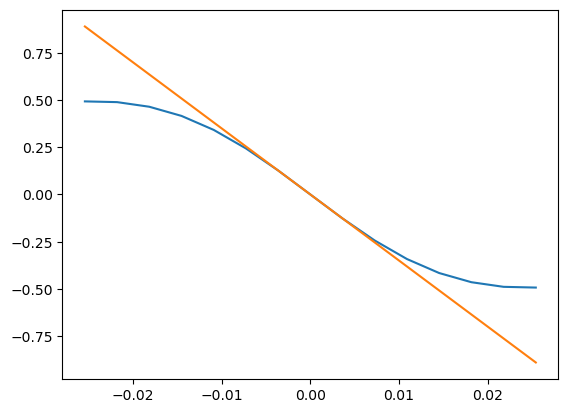

In [11]:
popt, pcov = curve_fit(line, y[6:-6], By[8,:][6:-6]*1e4/1e2)
plt.plot(y, By[8,:]*1e4/1e2)
plt.plot(y, line(y, *popt))
print('gradient:', popt[0], 'G/cm')

In [12]:
y = np.linspace(-0.3*inch, 0.3*inch, 15)
x = np.linspace(-0.3*inch, 0.3*inch, 15)

rb = np.array([[np.array([xx,yy,0]) for yy in y] for xx in x])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(x))]).transpose()
By = B[:,:][1]
Bx = B[:,:][0]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bx**2+Bz**2)

C:\Users\klab\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\klab\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


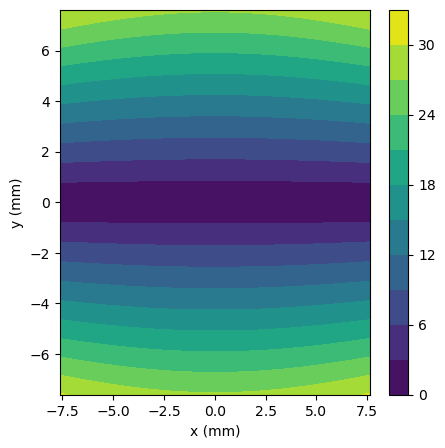

In [13]:
plt.figure(figsize=(5,5))
plot=plt.contourf(x*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],x[0],x[-1]], origin='lower', levels=10)
plt.quiver(x*1e3, y*1e3, Bx, By, color='white')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [14]:
num_array = np.linspace(1, 6, 10, endpoint=True)
grad_array = []

for num in num_array:
    y = np.linspace(-1*inch, 1*inch, 15)
    z = np.linspace(-1*inch, 1*inch, 15)

    rb = np.array([[np.array([0,yy,zz]) for yy in y] for zz in z])

    B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(z))]).transpose()
    Bx = B[:,:][0]
    By = B[:,:][1]
    Bz = B[:,:][2]
    Bmag = np.sqrt(By**2+Bz**2+Bx**2)
    
    popt, pcov = curve_fit(line, y[6:-6], By[8,:][6:-6]*1e4/1e2)
    grad_array.append(popt[0])

In [15]:
conv_grad = np.mean(np.divide(grad_array, num_array))

# Monte Carlo

https://arxiv.org/abs/physics/0103085v1

In [17]:
L = 1
S = 0
J = 1
I = 1/2
F = 3/2

gJ = 3/2 + (S*(S+1) - L*(L+1)) / 2 / J / (J+1)  
gF = (F*(F+1) + J*(J+1) - I*(I+1)) / 2 / F / (F+1) * gJ


In [18]:
def Zeeman_shift(dmF, r):

    B = np.sqrt(np.sum(np.square(Bfield(r))))
    
    return mB*gF*B*dmF/hbar

In [19]:
def epsilon(k, q):
    knorm = k/np.linalg.norm(k)
    ihat = x
    jhat = knorm
    khat = np.cross(ihat, jhat)
    
    if q==1:
        return -1/np.sqrt(2)*(z+1j*ihat)
    elif q==0:
        return jhat
    elif q==-1:
        return 1/np.sqrt(2)*(z-1j*ihat)

def rotation_matrix(k, r, pol):
    knorm = k/np.linalg.norm(k)
    B = Bfield(r)
    Bnorm = B/np.linalg.norm(B)
    cos = np.dot(knorm, Bnorm)
    sin = np.sqrt(1-cos**2)
    
    Mq = 1/2* np.array( [[1+cos, -np.sqrt(2)*sin, 1-cos], 
                           [np.sqrt(2)*sin, 2*cos, -np.sqrt(2)*sin], 
                           [1-cos, np.sqrt(2)*sin, 1+cos] ]  )
    
    return np.matmul(Mq,pol)

In [75]:
def RK4(xn, vn, f):
    
    h = dt

    k1x = vn
    k1v = f(xn, vn)/m171
    
    k2x = vn + k1v*h/2
    k2v = f(xn + k1x*h/2, vn + k1v*h/2)/m171
    
    k3x = vn + k2v*h/2
    k3v = f(xn + k2x*h/2, vn + k2v*h/2)/m171
    
    k4x = vn + k3v*h
    k4v = f(xn + k3x*h, vn + k3v*h)/m171
    
    vn1 = vn + (k1v + 2*k2v + 2*k3v + k4v)*(h/6)
    xn1 = xn + (k1x + 2*k2x + 2*k3x + k4x)*(h/6)

    return xn1, vn1, f(xn, vn)

In [84]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

ki = k*np.array( [ -y+z, -y-z, y+z, y-z]) #, -y+z, -y-z wavevectors of the mot beams
poli = np.array( [ epsilon(ki[0], -1), epsilon(ki[1], 1), epsilon(ki[2], 1), epsilon(ki[3], -1)]) #

kslower = -y*k
polslower = x

In [ ]:
import numpy as np
import scipy.constants as sc

# mot beam, has waist position r0, waist w0, wavevector k, transition natural linewidth gamma, detuning from resonance gamma (<0 for red detuned)
# saturation parameter s0 = Is/I0 at the waist, polarization pol = +/-1 for right-handed/left-handed beam

class motBeam:

	def __init__(self, k, w0, r0, gamma, delta, s0, pol):
		self.k = k
		self.km = np.sqrt(np.sum(self.k**2))
		self.r0 = r0
		self.w0 = w0
		self.gamma = gamma
		self.delta = delta
		self.s0 = s0
		self.pol = pol
	

	# beam intensity at r, in units of saturation intensity
	def Sat(self, r):
		dr = np.array([r[0]-self.r0[0], r[1]-self.r0[1], r[2]-self.r0[2]])
		drm = np.sqrt(np.sum(dr**2, axis=0)) + 1e-15
		kdotdr = self.k[0]*dr[0]+self.k[1]*dr[1]+self.k[2]*dr[2]
		theta = np.arccos(kdotdr/(drm*self.km))
		z = drm*np.cos(theta)
		rho = np.abs(drm*np.sin(theta))
		return self.s0*((self.w(z)/self.w0)**2) * np.exp( (-2*(rho**2))/((self.w(z))**2) )
	
	# calculates the beams average force on an array of atoms at positions r with velocities v for a transition with effective dipole muEff
	# in a quadrapole field with gradient Bp in all directions
	def FBeam(self, r, v, muEff, Bp):
		dr = np.array([r[0]-self.r0[0], r[1]-self.r0[1], r[2]-self.r0[2]])
		drm = np.sqrt(np.sum(dr**2, axis=0)) + 1e-15
		kdotdr = self.k[0]*dr[0]+self.k[1]*dr[1]+self.k[2]*dr[2]
		kdotv = self.k[0]*v[0]+self.k[1]*v[1]+self.k[2]*v[2]
		theta = np.arccos(kdotdr/(drm*self.km))
		Fkir = ((0.5*(1-np.cos(theta)))**2)/(1 + self.Sat(dr) + (2*(self.delta-kdotv+self.pol*muEff*Bp*drm/sc.hbar)/self.gamma)**2)
		Fkil = ((0.5*(1+np.cos(theta)))**2)/(1 + self.Sat(dr) + (2*(self.delta-kdotv-self.pol*muEff*Bp*drm/sc.hbar)/self.gamma)**2)
		Fkitot = (sc.hbar*self.km*self.gamma*self.Sat(dr)/2)*(Fkir + Fkil)
		Fkixyz = np.outer(self.k/self.km, Fkitot)
		return Fkixyz
	

# shell beam is a p=0, l=2 Laguerre-Gaussian mode for now. Not sure what we're going to get in the experiment 
class motBeamShell(motBeam):
	def Sat(self, r):
		dr = np.array([r[0]-self.r0[0], r[1]-self.r0[1], r[2]-self.r0[2]])
		drm = np.sqrt(np.sum(dr**2, axis=0)) + 1e-15
		kdotdr = self.k[0]*dr[0]+self.k[1]*dr[1]+self.k[2]*dr[2]
		theta = np.arccos(kdotdr/(drm*self.km))
		z = drm*np.cos(theta)
		rho = np.abs(drm*np.sin(theta))
		return self.s0*np.sqrt(1/np.pi) * (self.w(z)/self.w0) * ((rho*np.sqrt(2)/self.w(z))**2) * np.exp( (-(rho**2))/((self.w(z))**2) ) #* (1-(rho**2)/((self.w(z))**2))
	
class motBeamSquare(motBeam):
	def Sat(self, r):
		dr = np.array([r[0]-self.r0[0], r[1]-self.r0[1], r[2]-self.r0[2]])
		drm = np.sqrt(np.sum(dr**2, axis=0)) + 1e-15
		kdotdr = self.k[0]*dr[0]+self.k[1]*dr[1]+self.k[2]*dr[2]
		theta = np.arccos(kdotdr/(drm*self.km))
		z = drm*np.cos(theta)
		rho = np.abs(drm*np.sin(theta))
		return self.s0*( np.heaviside(rho+w0,0.5)*np.heaviside(-rho+w0,0.5) )

# plot the MOT beams
def plotBeams(ax, kis, plotSize, beamLength, colors=['#9FCC3B'], beamWidth=1, **kw):
		if (len(colors) < len(kis)):
			colors=np.repeat(colors,len(kis))
		for i in range(len(kis)):
			ki = kis[i]
			arrow3d(ax, length=beamLength, width=beamWidth, theta_x=np.arccos(ki.k[2]/ki.km), color=colors[i],
					theta_z=np.arctan2(ki.k[0],-ki.k[1]), offset=(-plotSize*ki.k[0]/ki.km+ki.r0[0]*(1e3),
																  -plotSize*ki.k[1]/ki.km+ki.r0[1]*(1e3),
																  -plotSize*ki.k[2]/ki.km+ki.r0[2]*(1e3)), **kw)

#arrow shape for MOT beams
def arrow3d(ax, length=1, width=0.05, head=0.2, headwidth=1,
				theta_x=0, theta_z=0, offset=(0,0,0), **kw):
	w = width
	h = head
	hw = headwidth
#     theta_x = np.deg2rad(theta_x)
#     theta_z = np.deg2rad(theta_z)

	a = [[0,0],[w,0],[w,(1-h)*length],[hw*w,(1-h)*length],[0,length]]
	a = np.array(a)

	r, theta = np.meshgrid(a[:,0], np.linspace(0,2*np.pi,30))
	z = np.tile(a[:,1],r.shape[0]).reshape(r.shape)
	x = r*np.sin(theta)
	y = r*np.cos(theta)

	rot_x = np.array([[1,0,0],[0,np.cos(theta_x),-np.sin(theta_x) ],
					  [0,np.sin(theta_x) ,np.cos(theta_x) ]])
	rot_z = np.array([[np.cos(theta_z),-np.sin(theta_z),0 ],
					  [np.sin(theta_z) ,np.cos(theta_z),0 ],[0,0,1]])

	b1 = np.dot(rot_x, np.c_[x.flatten(),y.flatten(),z.flatten()].T)
	b2 = np.dot(rot_z, b1)
	b2 = b2.T+np.array(offset)
	x = b2[:,0].reshape(r.shape); 
	y = b2[:,1].reshape(r.shape); 
	z = b2[:,2].reshape(r.shape); 
	ax.plot_surface(x,y,z, **kw)
